In [ ]:
#------------------------ Import required libraries ------------------#
import matplotlib.pyplot as plt
import os
import torch
import numpy as np
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision import models
from sklearn.preprocessing import label_binarize
import torch.optim as optim
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

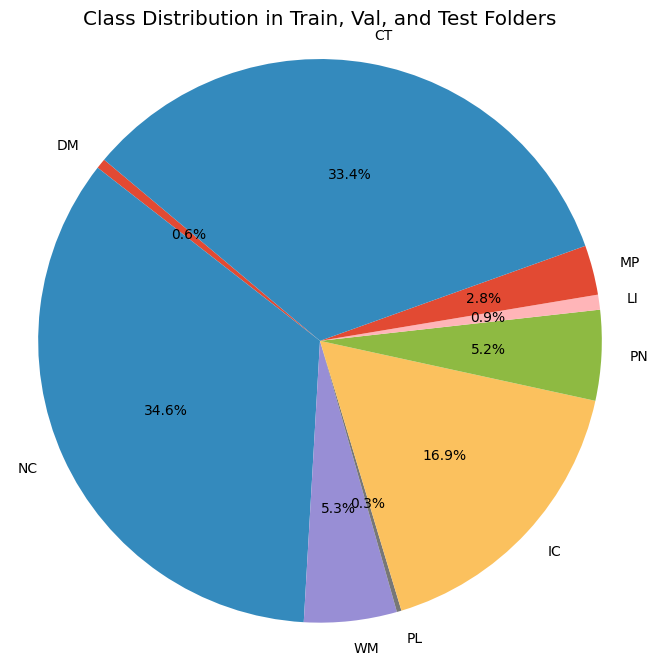


Class Information:
Total training images: 524476
Total validation images: 112378
Total test images: 112408
Total images in all splits: 749262

Total images per class (across all splits):
CT: 250370 images
DM: 4358 images
IC: 126772 images
LI: 6418 images
MP: 21348 images
NC: 259328 images
PL: 1998 images
PN: 38820 images
WM: 39850 images


In [ ]:
#------------- Show dataset statistics ------------#
# Define the paths
train_dir = 'brats-path-2025/train'
val_dir = 'brats-path-2025/val'
test_dir = 'brats-path-2025/test'

# Initialize class count dictionaries
train_counts = {}
val_counts = {}
test_counts = {}

# Total image counters
total_train_images = 0
total_val_images = 0
total_test_images = 0

# Function to count images in a directory
def count_images(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len([f for f in files if f.endswith(('.jpg', '.png', '.jpeg'))])
    return count

# Count class-wise images
def count_split_images(base_dir, counter_dict):
    total = 0
    if not os.path.exists(base_dir):
        return 0
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):
            count = count_images(class_path)
            counter_dict[class_name] = count
            total += count
    return total

# Count images
total_train_images = count_split_images(train_dir, train_counts)
total_val_images = count_split_images(val_dir, val_counts)
total_test_images = count_split_images(test_dir, test_counts)

# Combine all class-wise counts
all_class_names = set(train_counts) | set(val_counts) | set(test_counts)
total_images_per_class = {
    cls: train_counts.get(cls, 0) + val_counts.get(cls, 0) + test_counts.get(cls, 0)
    for cls in all_class_names
}

# Prepare data for pie chart
class_names = list(total_images_per_class.keys())
class_distributions = list(total_images_per_class.values())

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(class_distributions, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution in Train, Val, and Test Folders')
plt.axis('equal')
plt.show()

# Print results
print("\nClass Information:")
print(f"Total training images: {total_train_images}")
print(f"Total validation images: {total_val_images}")
print(f"Total test images: {total_test_images}")
print(f"Total images in all splits: {total_train_images + total_val_images + total_test_images}")
print("\nTotal images per class (across all splits):")
for class_name in sorted(total_images_per_class):
    print(f"{class_name}: {total_images_per_class[class_name]} images")


In [ ]:
#------------- Calculate total number of classes ----------#
num_classes = len(os.listdir(train_dir))
print('Total Classes: ', num_classes)

Total Classes:  9


In [ ]:
#----------- Check if CUDA (GPU) is available ------------#

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


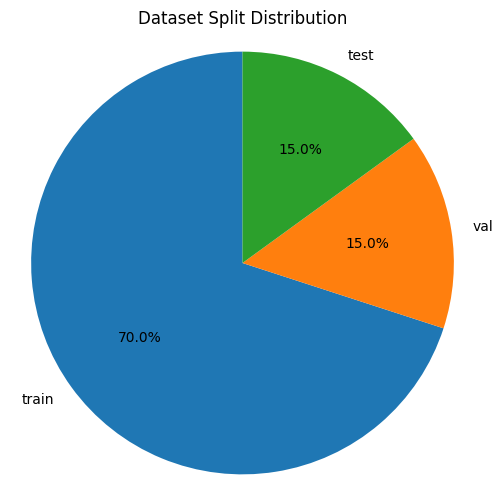

In [ ]:
#----------------- Plot split percentage ------------------#

data_root = "brats-path-2025"
splits = ['train', 'val', 'test']
split_counts = {}

for split in splits:
    count = 0
    split_path = os.path.join(data_root, split)
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        if os.path.isdir(class_path):
            count += len([f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
    split_counts[split] = count

# Pie chart
plt.figure(figsize=(6,6))
plt.pie(split_counts.values(), labels=split_counts.keys(), autopct='%1.1f%%', startangle=90)
plt.title('Dataset Split Distribution')
plt.axis('equal')
plt.show()


In [ ]:
#----------------- Define Dataset and DataLoaders ------------------#

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Datasets
train_dataset = datasets.ImageFolder(os.path.join(data_root, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_root, 'val'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(data_root, 'test'), transform=transform)



In [ ]:
!pip install optuna

In [ ]:
import optuna
import optuna.visualisation.matplotlib as optuna_vis

In [ ]:
def objective(trial):
    # Hyperparameters to try
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    dropout = trial.suggest_uniform('dropout', 0.1, 0.5)
    unfreeze_layers = trial.suggest_int('unfreeze_layers', 2, 5)

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Model setup
    weights = MobileNet_V2_Weights.DEFAULT
    model = mobilenet_v2(weights=weights)

    # Replace classifier with dropout
    model.classifier = nn.Sequential(
        nn.Dropout(p=dropout),
        nn.Linear(model.last_channel, len(class_names))
    )

    # Freeze all parameters
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last N layers
    if unfreeze_layers > 0:
        child_counter = 0
        for child in reversed(list(model.features.children())):
            if child_counter >= unfreeze_layers:
                break
            for param in child.parameters():
                param.requires_grad = True
            child_counter += 1

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    class EarlyStopping:
        def __init__(self, patience=3):
            self.patience = patience
            self.counter = 0
            self.best_acc = 0
            self.early_stop = False

        def __call__(self, val_acc):
            if val_acc > self.best_acc:
                self.best_acc = val_acc
                self.counter = 0
            else:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True

    early_stopper = EarlyStopping(patience=3)

    # Training
    num_epochs = 2
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_acc = correct / total
        early_stopper(val_acc)
        if early_stopper.early_stop:
            break

    return val_acc  # ⬅️ Maximize this!


In [ ]:
study = optuna.create_study(direction='maximize')  # ⬅️ maximize accuracy
study.optimize(objective, n_trials=10)

[I 2025-07-09 11:04:21,546] A new study created in memory with name: no-name-47d5d40f-be82-465b-af47-64bc33e03bd0
/tmp/ipykernel_35/3875445609.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
/tmp/ipykernel_35/3875445609.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 165MB/s]
[I 2025-07-09 11:22:40,182] Trial 0 finished with value: 0.9577675345708234 and parameters: {'lr': 0.00248004937666225, 'batch

In [ ]:
print("Best trial:")
trial = study.best_trial
print(f"  Accuracy: {trial.value:.4f}")
print("  Best hyperparameters:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


Best trial:
  Accuracy: 0.9782
  Best hyperparameters:
    lr: 0.0001962773641024452
    batch_size: 32
    dropout: 0.11857398122994295
    unfreeze_layers: 4


/tmp/ipykernel_35/1473583576.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_vis.plot_optimization_history(study)


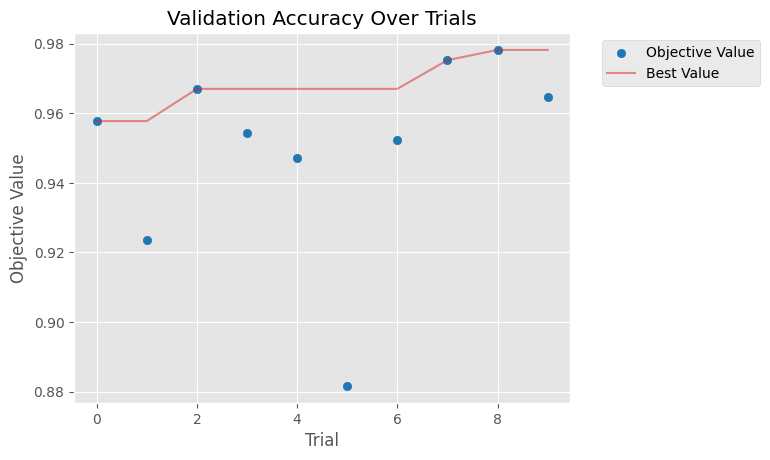

In [ ]:
# Accuracy over trials
optuna_vis.plot_optimization_history(study)
plt.title("Validation Accuracy Over Trials")
plt.show()

/tmp/ipykernel_35/2918244600.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_vis.plot_param_importances(study)


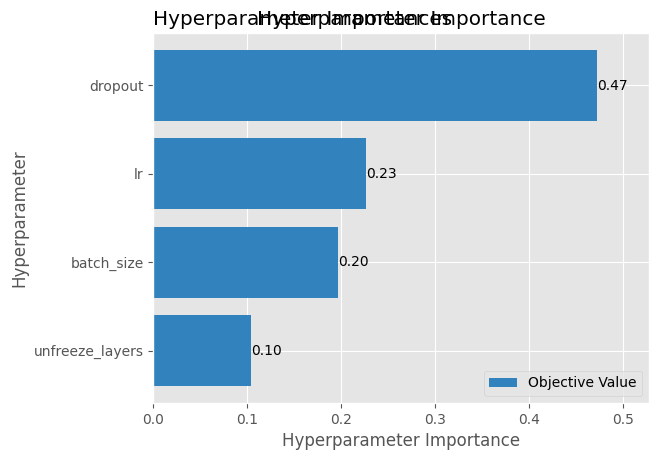

In [ ]:
optuna_vis.plot_param_importances(study)
plt.title("Hyperparameter Importance")
plt.show()

/tmp/ipykernel_35/2199429449.py:1: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_vis.plot_parallel_coordinate(study)


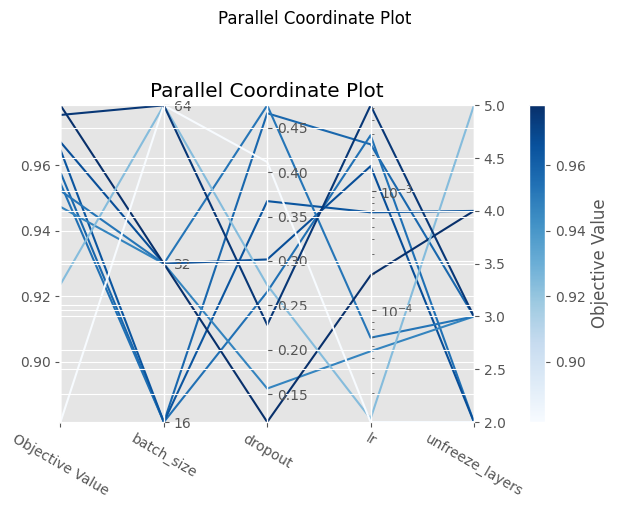

In [ ]:
optuna_vis.plot_parallel_coordinate(study)
plt.suptitle("Parallel Coordinate Plot", y=1.05)
plt.tight_layout()
plt.show()

/tmp/ipykernel_35/2666226073.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_vis.plot_slice(study)
/tmp/ipykernel_35/2666226073.py:3: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


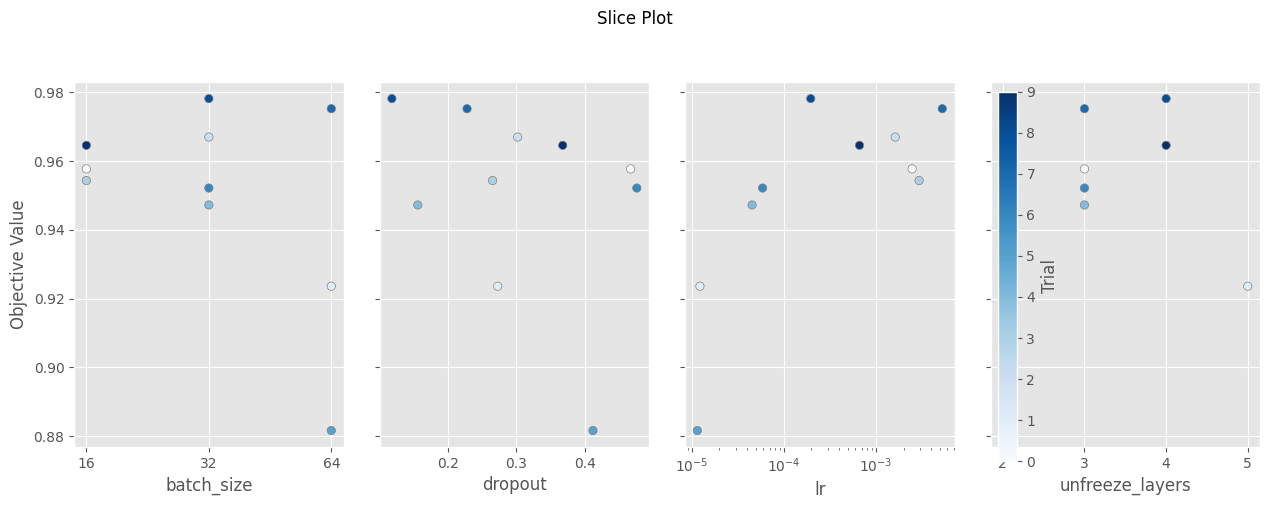

In [ ]:
optuna_vis.plot_slice(study)
plt.suptitle("Slice Plot", y=1.05)
plt.tight_layout()
plt.show()

In [ ]:
best_params = study.best_trial.params

lr = best_params['lr']
batch_size = best_params['batch_size']
dropout = best_params['dropout']
unfreeze_layers = best_params['unfreeze_layers']


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [ ]:
# Load model with weights
model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)

# Replace classifier
model.classifier = nn.Sequential(
    nn.Dropout(p=dropout),
    nn.Linear(model.last_channel, len(class_names))
)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last `unfreeze_layers` blocks
if unfreeze_layers > 0:
    child_counter = 0
    for child in reversed(list(model.features.children())):
        if child_counter >= unfreeze_layers:
            break
        for param in child.parameters():
            param.requires_grad = True
        child_counter += 1

model = model.to(device)

# Optimizer & scheduler
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [ ]:
#----------------- Define Loss, Optimizer, Scheduler, EarlyStopping ------------------#

# Early stopping
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [ ]:
#----------------- Train the Model with 100-Step Progress Display ------------------#

num_epochs = 5
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

early_stopper = EarlyStopping(patience=5)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    num_batches = len(train_loader)

    print(f"Epoch: {epoch + 1} | ", end="", flush=True)

    progress_shown = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Progress bar
        percentage_complete = (batch_idx + 1) / num_batches
        bar_ticks = int(percentage_complete * 100)
        while progress_shown < bar_ticks:
            print("-", end="", flush=True)
            progress_shown += 1

    print(f" ({progress_shown})")

    train_acc = correct / total
    train_losses.append(train_loss / num_batches)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_acc = correct / total
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_acc)

    # Print metrics after epoch
    print(f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.4f}\n")

    scheduler.step()
    early_stopper(val_losses[-1])
    if early_stopper.early_stop:
        print("Early stopping triggered.")
        break


Epoch: 1 | ---------------------------------------------------------------------------------------------------- (100)
Train Loss: 0.2639, Train Acc: 0.9194, Val Loss: 0.0953, Val Acc: 0.9695

Epoch: 2 | ---------------------------------------------------------------------------------------------------- (100)
Train Loss: 0.1114, Train Acc: 0.9636, Val Loss: 0.0658, Val Acc: 0.9787

Epoch: 3 | ---------------------------------------------------------------------------------------------------- (100)
Train Loss: 0.0738, Train Acc: 0.9759, Val Loss: 0.0507, Val Acc: 0.9832

Epoch: 4 | ---------------------------------------------------------------------------------------------------- (100)
Train Loss: 0.0538, Train Acc: 0.9821, Val Loss: 0.0426, Val Acc: 0.9864

Epoch: 5 | ---------------------------------------------------------------------------------------------------- (100)
Train Loss: 0.0419, Train Acc: 0.9864, Val Loss: 0.0443, Val Acc: 0.9855



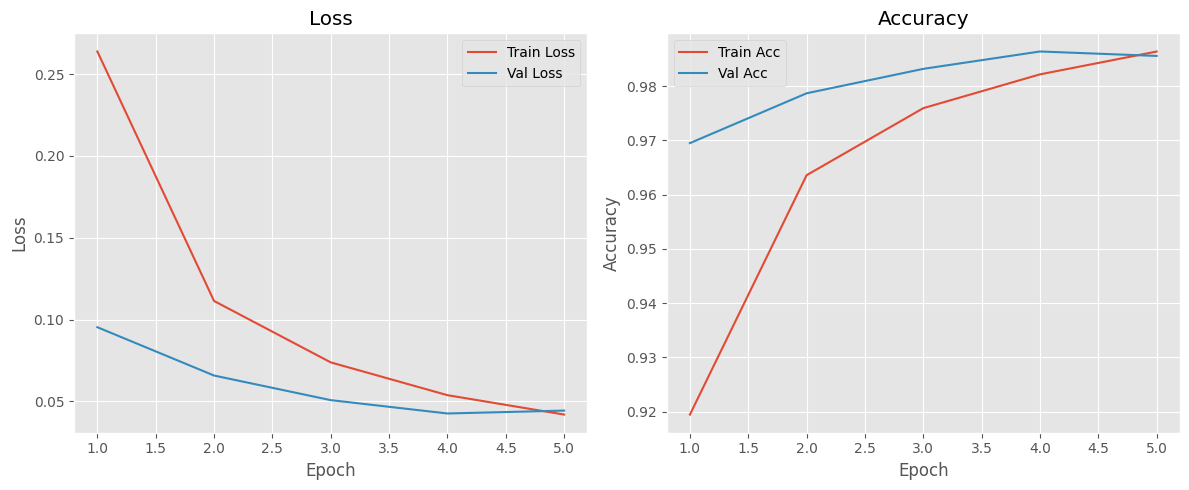

In [ ]:
#----------------- Plot Training & Validation Loss and Accuracy ------------------#

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
#----------------- Evaluate on Test Set ------------------#

model.eval()
all_preds = []
all_labels = []

num_batches = len(test_loader)
progress_shown = 0
print("Evaluating on Test Set | ", end="", flush=True)

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

        # Show progress bar
        percentage_complete = (batch_idx + 1) / num_batches
        bar_ticks = int(percentage_complete * 100)
        while progress_shown < bar_ticks:
            print("-", end="", flush=True)
            progress_shown += 1

print(f" ({progress_shown})")

# Metrics
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='macro')
rec = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"\nTest Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")


Evaluating on Test Set | ---------------------------------------------------------------------------------------------------- (100)

Test Accuracy: 0.9854
Precision: 0.9416
Recall: 0.9616
F1 Score: 0.9505


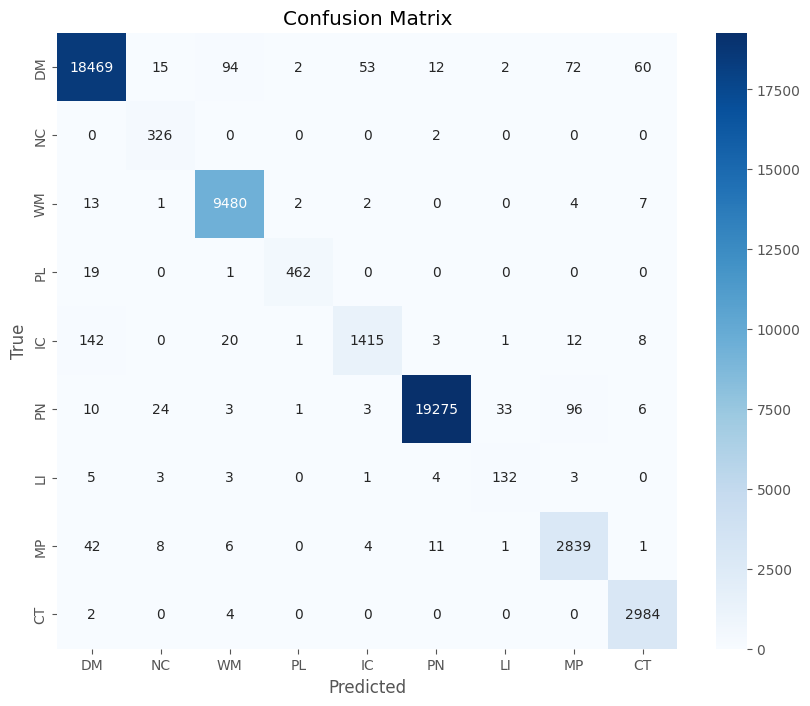

In [ ]:
#----------------- Plot Confusion Matrix ------------------#

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


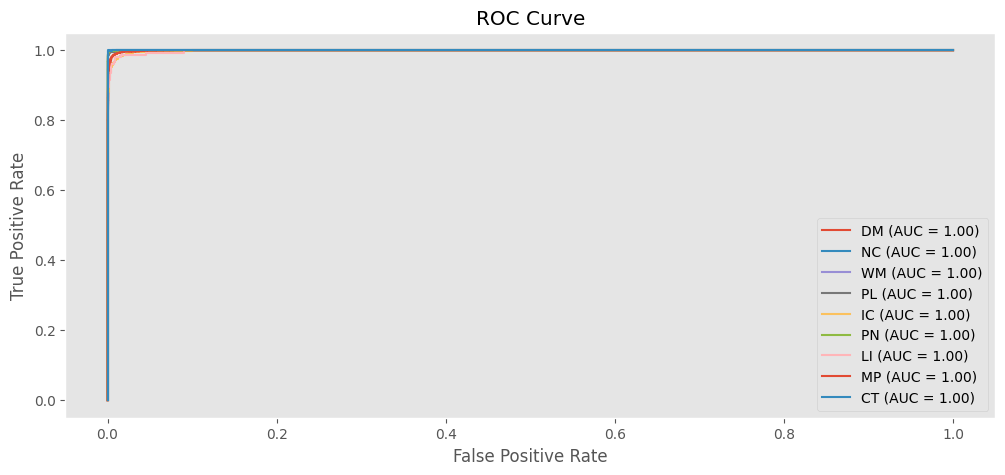

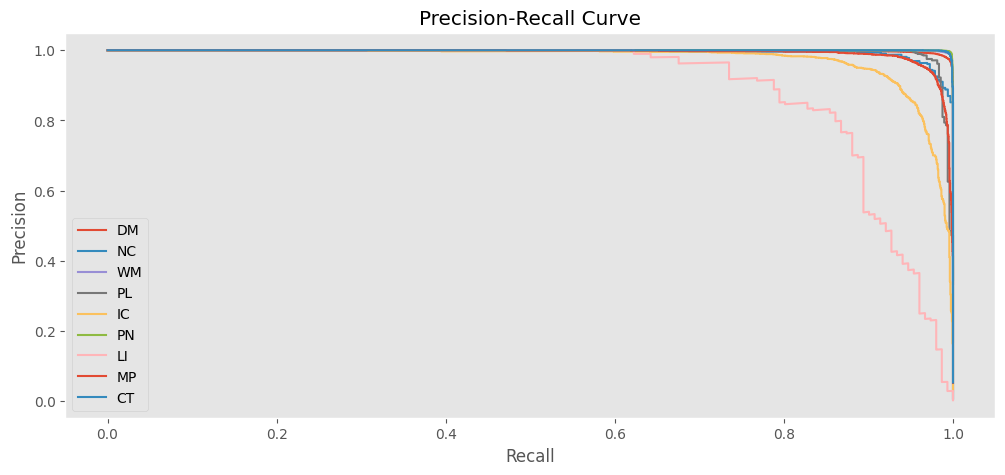

In [ ]:
#----------------- Plot ROC-AUC & Precision-Recall Curves ------------------#


# One-hot encode the labels
y_test_bin = label_binarize(all_labels, classes=range(len(class_names)))

# Predict probabilities
all_probs = []
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())

all_probs = np.array(all_probs)

# ROC-AUC Plot
plt.figure(figsize=(12, 5))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {auc_score:.2f})')

plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# Precision-Recall Plot
plt.figure(figsize=(12, 5))
for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], all_probs[:, i])
    plt.plot(recall, precision, label=f'{class_names[i]}')

plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()


In [ ]:
#----------------- Print Class-wise Performance ------------------#

# Ensure inputs are numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Prepare storage
class_metrics = {
    "Class": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": []
}

# Calculate per-class metrics
for i, class_name in enumerate(class_names):
    # Binary masks for current class
    true_mask = (all_labels == i)
    pred_mask = (all_preds == i)

    # Accuracy: proportion of correctly predicted samples for this class only
    class_correct = np.sum(true_mask & pred_mask)
    class_total = np.sum(true_mask)
    class_acc = class_correct / class_total if class_total > 0 else 0.0

    # Precision, Recall, F1 (use average='binary' on masks)
    prec = precision_score(true_mask, pred_mask, zero_division=0)
    rec = recall_score(true_mask, pred_mask, zero_division=0)
    f1 = f1_score(true_mask, pred_mask, zero_division=0)

    # Store results
    class_metrics["Class"].append(class_name)
    class_metrics["Accuracy"].append(round(class_acc, 4))
    class_metrics["Precision"].append(round(prec, 4))
    class_metrics["Recall"].append(round(rec, 4))
    class_metrics["F1-Score"].append(round(f1, 4))

# Display as DataFrame
df_class_metrics = pd.DataFrame(class_metrics)
print("Class-wise Performance Metrics:\n")
print(df_class_metrics)


Class-wise Performance Metrics:

  Class  Accuracy  Precision  Recall  F1-Score
0    DM    0.9835     0.9875  0.9835    0.9855
1    NC    0.9939     0.8647  0.9939    0.9248
2    WM    0.9970     0.9864  0.9970    0.9916
3    PL    0.9585     0.9872  0.9585    0.9726
4    IC    0.8833     0.9574  0.8833    0.9188
5    PN    0.9910     0.9983  0.9910    0.9946
6    LI    0.8742     0.7811  0.8742    0.8250
7    MP    0.9749     0.9382  0.9749    0.9562
8    CT    0.9980     0.9733  0.9980    0.9855


In [ ]:
#----------------- Predict on Validation-Data-anoymized and Save CSV ------------------#

anon_folder = "Validation-Data-anoymized"
image_paths = [os.path.join(anon_folder, fname)
               for fname in os.listdir(anon_folder)
               if fname.lower().endswith(('.jpg', '.jpeg', '.png'))]

model.eval()
predictions = []

# Define transform (same as train)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

with torch.no_grad():
    for img_path in tqdm(image_paths):
        image = Image.open(img_path).convert('RGB')
        input_tensor = preprocess(image).unsqueeze(0).to(device)

        output = model(input_tensor)
        prob = torch.softmax(output, dim=1)
        conf_score, predicted_class = torch.max(prob, 1)

        predictions.append({
            "Image-Name": os.path.basename(img_path),
            "Predicted Class": class_names[predicted_class.item()],
            "Confidence Score": conf_score.item()
        })

# Create DataFrame
val_predictions = pd.DataFrame(predictions)
val_predictions.to_csv("val_predictions.csv", index=False)
print("Saved as val_predictions.csv")

# Show DataFrame
val_predictions.head()


100%|██████████| 294/294 [00:05<00:00, 54.75it/s]

Saved as val_predictions.csv


,Image-Name,Predicted Class,Confidence Score
0,BraTSPath_Val_0000105.png,DM,0.968614
1,BraTSPath_Val_0000074.png,PN,0.995096
2,BraTSPath_Val_0000151.png,PN,0.999677
3,BraTSPath_Val_0000289.png,MP,0.868298
4,BraTSPath_Val_0000096.png,NC,0.433324


In [ ]:
from sklearn.metrics import confusion_matrix, matthews_corrcoef
import numpy as np

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
class_specificity = []
class_mcc = []

for i in range(len(class_names)):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0.0
    class_specificity.append(specificity)

    # Binary MCC for class i
    binary_true = [1 if label == i else 0 for label in all_labels]
    binary_pred = [1 if pred == i else 0 for pred in all_preds]
    mcc = matthews_corrcoef(binary_true, binary_pred)
    class_mcc.append(mcc)

# Print class-wise results
print("\nClass-wise Specificity and MCC:")
for i, class_name in enumerate(class_names):
    print(f"{class_name:>3}: Specificity = {class_specificity[i]:.4f}, MCC = {class_mcc[i]:.4f}")

# Global MCC
mcc_global = matthews_corrcoef(all_labels, all_preds)
print(f"\nGlobal MCC: {mcc_global:.4f}")



Class-wise Specificity and MCC:
 DM: Specificity = 0.9938, MCC = 0.9783
 NC: Specificity = 0.9991, MCC = 0.9266
 WM: Specificity = 0.9972, MCC = 0.9899
 PL: Specificity = 0.9999, MCC = 0.9725
 IC: Specificity = 0.9988, MCC = 0.9173
 PN: Specificity = 0.9991, MCC = 0.9918
 LI: Specificity = 0.9993, MCC = 0.8258
 MP: Specificity = 0.9965, MCC = 0.9540
 CT: Specificity = 0.9985, MCC = 0.9847

Global MCC: 0.9801
